## Genomics and High-Dimensional Data: Written Analysis, Peer Review and Discussion

### Problem 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, StratifiedKFold

#### Data Preparation

In [3]:
# Load the data
dataset = np.load("./data/p2_unsupervised/X.npy")

# Take the log 2 transform of the data
dataset = np.log2(dataset + 1)

# Number of cells (rows) and genes (columns)
n_cells, n_genes = dataset.shape
print(f"Number of cells: {n_cells}")
print(f"Number of genes: {n_genes}")

# Value of the largest entry in the first column of the transformed data
largest_entry_first_col = np.max(dataset[:, 0])
print(f"Largest entry in the first column of the transformed data: {largest_entry_first_col}")

Number of cells: 2169
Number of genes: 45768
Largest entry in the first column of the transformed data: 5.972169178513185


---

#### Part 1: Visualization

A scientist tells you that cells in the brain are either excitatory neurons, inhibitory neurons, or non-neuronal cells. Cells from each of these three groups serve different functions within the brain. Within each of these three types, there are numerous distinct sub-types that a cell can be, and sub-types of the same larger class can serve similar functions. Your goal is to produce visualizations which show how the scientist's knowledge reflects in the data.

1. (3 points) Provide at least one visualization which clearly shows the existence of three main brain cell types as described by the scientist, and explain how it shows this. Your visualization should support the idea that cells from a different group (for example, excitatory vs inhibitory) can differ greatly.

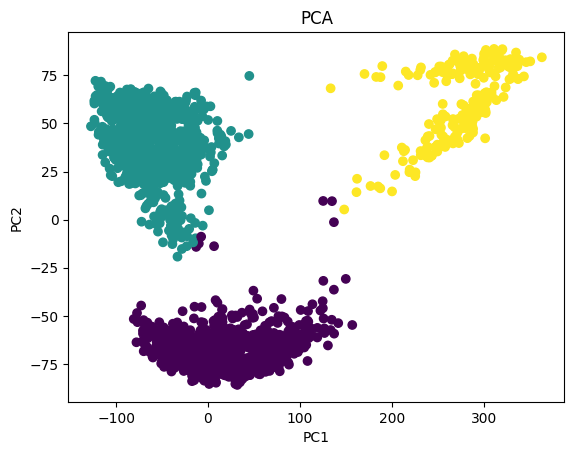

In [4]:
# ===================== PCA ==================== #

# Initialize the PCA, MDS, and t-SNE models
pca = PCA(n_components=2)

# Fit the models to the data
data_pca_fit = pca.fit(dataset)

# Transform the data using the models
data_transform_pca = data_pca_fit.transform(dataset)

# =================== KMEANS =================== #

# Initialize the KMeans model
# (We expect 3 cell types in the data, so we set n_clusters=3)
kmeans = KMeans(n_clusters=3, n_init=10)

# Fit the model to the data
kmeans_fit = kmeans.fit(dataset)

# Predict the cluster labels of the data
kmeans_labels = kmeans_fit.predict(dataset)

# ==================== PLOT ==================== #

# Plot the first two principal components of the PCA transform
plt.scatter(
    data_transform_pca[:, 0],
    data_transform_pca[:, 1],
    c=kmeans_labels,
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA")
plt.show()

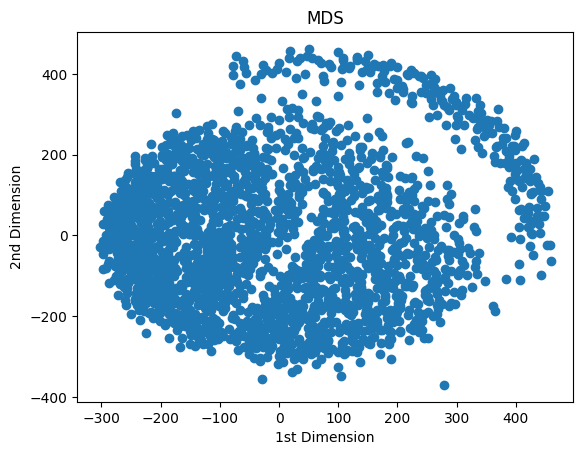

In [5]:
# ==================== MDS ==================== #

# Fit the data using MDS
mds_model = MDS(
    n_components=2,
    n_init=10,
    normalized_stress="auto",
    eps=1e-5
)
mds_fit = mds_model.fit(dataset)

# ==================== PLOT ==================== #

# Plot the first two principal components of the MDS transform
plt.scatter(
    mds_fit.embedding_[:, 0],
    mds_fit.embedding_[:, 1],
)
plt.xlabel("1st Dimension")
plt.ylabel("2nd Dimension")
plt.title("MDS")
plt.show()

- The visualization that more clearly displays the existence of 3 separate clusters is the plot of the first two principal components of the data. The PCA plot very clearly shows 3 distinct clusters that, despite a couple of outliers, are very easily separable. This is proven even more by the fact that by running the kmeans algorithm on the data, the resulting labels very closely match the perceived 3 clusters. The MDS plot could also be argued that it shows 3 clusters, but 2 of the three clusters are very close together. Since the chosen visualization should "support the idea that cells from a different group can differ greatly", the PCA plot is the better choice.

2. (4 points) Provide at least one visualization which supports the claim that within each of the three types, there are numerous possible sub-types for a cell. In your visualization, highlight which of the three main types these sub-types belong to. Again, explain how your visualization supports the claim.

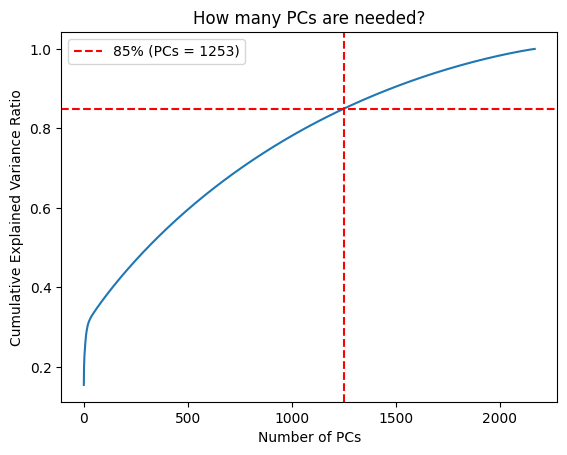

In [6]:
# ===== CUMULATIVE EXPLAINED VARIANCE RATIO ==== #

# Fit the data using PCA without limiting the number of PCs
data_pca_fit = PCA().fit(dataset)

# Get the cumulative explained variance ratio
cumulative_explained_variance_ratio = np.cumsum(data_pca_fit.explained_variance_ratio_)

# Plot the cumulative explained variance ratio
plt.plot(cumulative_explained_variance_ratio)

# Plot a horizontal line at 0.85
plt.axhline(y=0.85, color="r", linestyle="--")

# Get the number of PCs needed to explain 85% of the variance
n_pcs = np.argmax(cumulative_explained_variance_ratio >= 0.85) + 1

# Plot a vertical line at the number of PCs needed to explain 85% of the variance
plt.axvline(
    x=n_pcs, 
    color="r", 
    linestyle="--",
    label=f"85% (PCs = {n_pcs})",
)

# Label the axes
plt.xlabel("Number of PCs")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.title("How many PCs are needed?")
plt.legend()
plt.show()

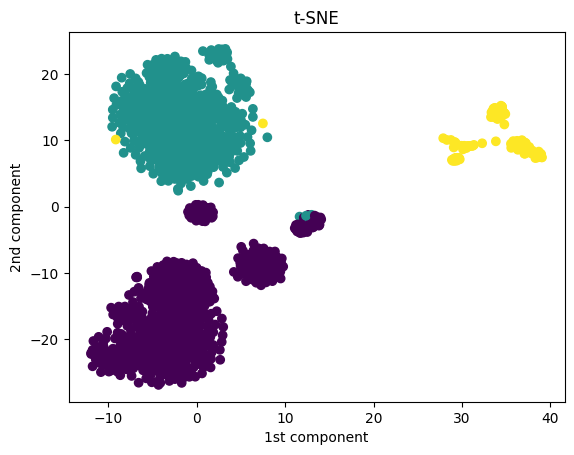

In [7]:
# ==================== TSNE ==================== #

# The dataset has way too many features. We bring them down to the number of 
# PCs needed to explain 85% of the variance using PCA
post_tsne_pca_fit = PCA(n_components=1250).fit(dataset)

# We fit the t-SNE model to the PCA-transformed data
tsne_fit = TSNE(n_components=2, perplexity=40).fit(post_tsne_pca_fit.transform(dataset))

# =================== KMEANS =================== #

# Initialize the KMeans model
# (We expect 3 cell types in the data, so we set n_clusters=3)
kmeans_model = KMeans(
    n_clusters=3, 
    n_init=10
)

# Fit the model to the data
kmeans_fit = kmeans_model.fit(post_tsne_pca_fit.transform(dataset))

# Predict the cluster labels of the data
kmeans_labels = kmeans_fit.predict(post_tsne_pca_fit.transform(dataset))

# ==================== PLOT ==================== #

# Plot the first two components of the t-SNE transform
plt.scatter(
    tsne_fit.embedding_[:, 0],
    tsne_fit.embedding_[:, 1],
    c=kmeans_labels,
)
plt.xlabel("1st component")
plt.ylabel("2nd component")
plt.title("t-SNE")
plt.show()


- The t-SNE visualization clearly supports the claim that within the three main cell types there are small possible sub-types. Once I accounted for the proper number of principal components to use for the first step of the dimensionality reduction (by calculating the number of principal components that explain 85% of the total variance), the t-SNE plot started displaying 3 distinct clusters that are clearly separated, with the difference (compared to the PCA plot presented previously) that it also shows the appearance of other smaller sub-clusters within each of the 3 main clusters. The perfect example of this is the cluster circled in red in the image below, as it is made up of a cluster of 3 or so "islands" or "sub-groups" placed close to each other. Each of those "islands" could be considered a sub-type of cell, supporting the claim that the dataset shows 3 main cell types.

![Alt text](images/islands.png)

#### Part 2: Unsupervised Feature Selection

Now we attempt to find informative genes which can help us differentiate between cells, using only unlabeled data. A genomics researcher would use specialized, domain-specific tools to select these genes. We will instead take a general approach using logistic regression in conjunction with clustering. Briefly speaking, we will use the p2_unsupervised dataset to cluster the data. Treating those cluster labels as ground truth, we will fit a logistic regression model and use its coefficients to select features. Finally, to evaluate the quality of these features, we will fit another logistic regression model on the training set in p2_evaluation, and run it on the test set in the same folder.

1. (4 points) Using your clustering method(s) of choice, find a suitable clustering for the cells. Briefly explain how you chose the number of clusters by appropriate visualizations and/or numerical findings.

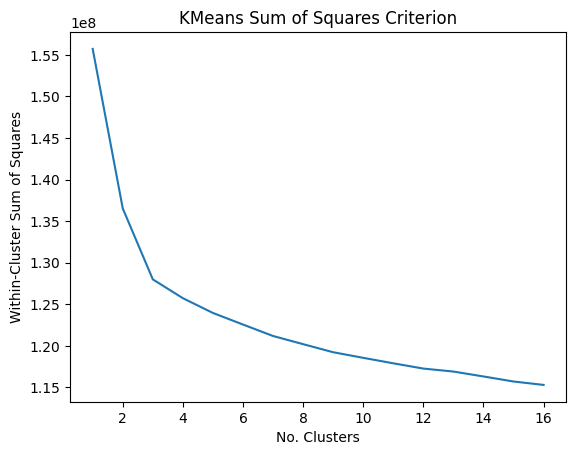

In [12]:
# ========== SUM OF SQUARES CRITERION ========== #

# Number of clusters to try
num_clusters = 16

# Compile the results of running the KMeans algorithm with different numbers of clusters
# Warning: This section will take a while to run (in my machine it took ~45 minutes)
all_kmeans = [
    KMeans(n_clusters=i+1, n_init=100) for i in range(num_clusters)
]

# Fit the data to each of the KMeans models and store the resulting "inertia"
inertias = [
    kmeans_model.fit(dataset).inertia_ for kmeans_model in all_kmeans
]


# ==================== PLOT ==================== #

plt.plot(
    np.arange(1, num_clusters + 1),
    inertias
)
plt.title("KMeans Sum of Squares Criterion")
plt.xlabel("No. Clusters")
plt.ylabel("Within-Cluster Sum of Squares")
plt.show()

In [13]:
# ============== SILHOUETTE SCORE ============== #

# Note: Remember that the Silhouette score is undefined for the class "1" so you need to 
# evaluate the score for the cluster 2 onwards (or cluster 1 in Python indexing terms)
avg_silhouette_scores = [
    silhouette_score(dataset, all_kmeans[i].labels_) for i in range(1, num_clusters)
]

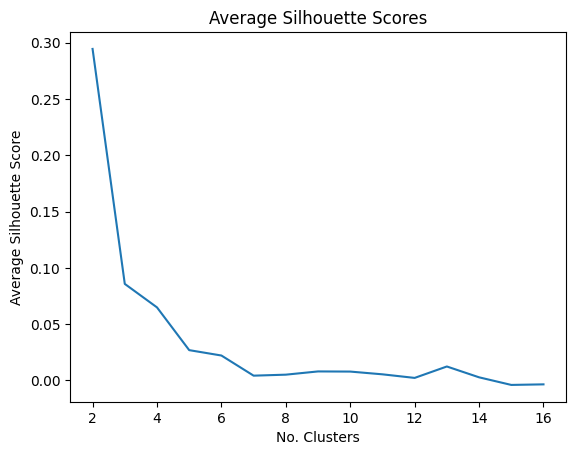

In [14]:
# ==================== PLOT ==================== #

plt.plot(
    np.arange(2, num_clusters+1),
    avg_silhouette_scores
)
plt.title("Average Silhouette Scores")
plt.xlabel("No. Clusters")
plt.ylabel("Average Silhouette Score")
plt.show()

- The number of clusters was chosen using the sum of squares criterion for the KMeans algorithm, since the dataset at hand has more than 45000 features and in the recitation it was mentioned that the Silhouette score is not a good metric for high dimensional data. The Silhouette score was still plotted, but the projected number of ideal clusters was unlikely as it suggested 2 (something that could be intuitively denied as all of the previous dimensionality reduction techniques showed at least 3 distinct clusters, except for the MDS method). The sum of squares criterion plot, on the other hand, showed an elbow (see graph above) at `k=3` or an ideal number of clusters of 3. This seems more reasonable as it matches the "scientist statement" given at the start of the problem: There are 3 types of neuron - Excitatory neurons, inhibitory neurons and non-neuronal cells. This will be the number of clusters used.

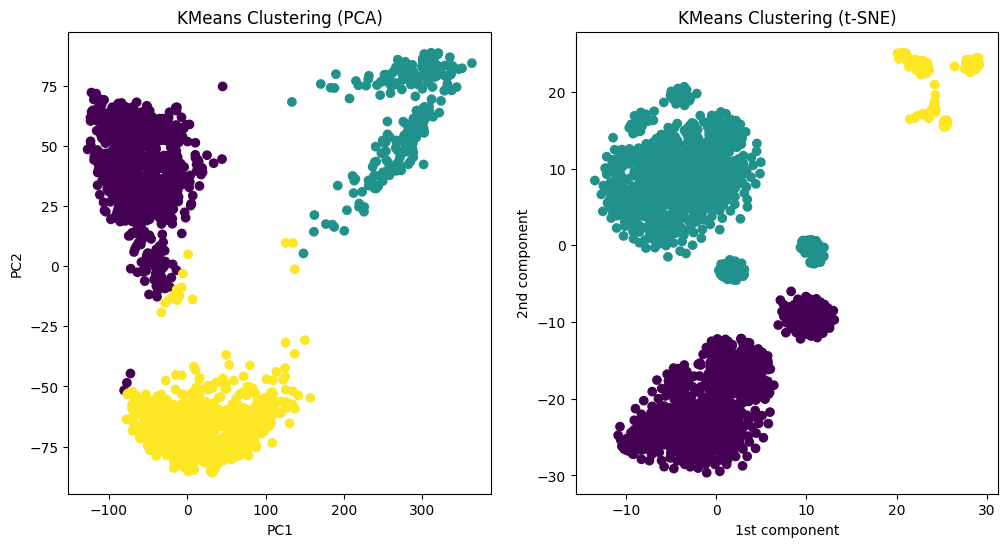

In [15]:
# ===================== PCA ==================== #

# Create a new subset of the dataset with only the first two PCs
dataset_pca = PCA(n_components=2).fit_transform(dataset)

# Cluster the data using KMeans with 3 clusters
pca_kmeans_model_fit = KMeans(n_clusters=3, n_init=100).fit(dataset_pca)

# ==================== TSNE ==================== #

# Create a pre-t-SNE PCA model with 1250 PCs 
# (The number of PCs needed to explain 85% of the variance)
pre_tsne_pca_fit = PCA(n_components=1250).fit(dataset)

# Create and fit a t-SNE model to the PCA-transformed data
tsne_model_fit = TSNE(n_components=2, perplexity=40).fit(pre_tsne_pca_fit.transform(dataset))

# Cluster the data using KMeans with 3 clusters
tsne_kmeans_model_fit = KMeans(n_clusters=3, n_init=100).fit(tsne_model_fit.embedding_)

# ==================== PLOT ==================== #

# Create a figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first two principal components of the PCA transform
ax1.scatter(
    dataset_pca[:, 0],
    dataset_pca[:, 1],
    c=pca_kmeans_model_fit.labels_,
)
ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")
ax1.set_title("KMeans Clustering (PCA)")

# Plot the first two coordinates of the t-SNE transform
ax2.scatter(
    tsne_model_fit.embedding_[:, 0],
    tsne_model_fit.embedding_[:, 1],
    c=tsne_kmeans_model_fit.labels_,
)
ax2.set_xlabel("1st component")
ax2.set_ylabel("2nd component")
ax2.set_title("KMeans Clustering (t-SNE)")

plt.show()

- I compared the clustering results for the two dimensionality reduction algorithms that previously displayed the best results: PCA and t-SNE. Both returned very distinct 3-cluster solutions, but the t-SNE solution is slightly cleaner as it shows less outliers visually appearing in the wrong cluster. Because of this, the t-SNE labels will be used for the rest of the problem.

In [16]:
# Define the labels used for the dataset 
dataset_labels = tsne_kmeans_model_fit.labels_

2. (6 points) We will now treat your cluster assignments as labels for supervised learning. Fit a logistic regression model to the original data (not principal components), with your clustering as the target labels. Since the data is high-dimensional, make sure to regularize your model using your choice of $l_1$, $l_2$, or elastic net, and separate the data into training and validation or use cross-validation to select your model. Report your choice of regularization parameter and validation performance.

   **Multi-class logistic regression**: When the underlying data has more than two classes involved, we can adapt Logistic Regression which is usually used for binary classification by one-versus-rest approach. In particular, if we have $K$ classes, we train $K$ separate binary classification models using logistic regression. Each classifier $f_k$ for $k \in \{1, \dots, K\}$ is trained to determine the probability of a data point belonging to class $k$. To predict the class for a new point $x$, we run all $K$ classifiers on $x$ and choose the class with the highest probability, i.e.,

   $$\widehat{y}= \text {argmax}_{k\in \{ 1,\dots , K\} } f_{k}(x).$$

   **Python tip**: You may use `liblinear` solver in `LogisticRegression` or `LogisticRegressionCV` for one-versus-rest logistic regression.

   **Note**: Recall that the `p2_unsupervised_reduced` and `p2_evaluation_reduced` folders contain datasets with a reduced number of genes, in case you are unable to run some of the procedures on the larger versions. In particular, a full logistic regression could take 1 or 2 GB of memory to run.

In [35]:
# ============== TRAIN TEST SPLIT ============== #

# Generate the training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    dataset,
    dataset_labels,
    test_size=0.3,
    random_state=42,
)

# Logistic regression model
# Note: L2 regularization causes the coefficients to be small, while L1 regularization
# causes the coefficients to be sparse (i.e. most of them are zero).
logistic_regression_model_split = LogisticRegression(
    solver="liblinear",
    C = 0.1,
    multi_class="ovr",
    max_iter = 5000,
    penalty="l1",
)

# Fit the model to the training data
log_reg_split_fit = logistic_regression_model_split.fit(X_train, y_train)

# Predict the labels of the test set and its accuracy score
log_reg_split_pred = logistic_regression_model_split.predict(X_test)
split_accuracy_score = logistic_regression_model_split.score(X_test, y_test)

# Print the classification score
print(f"Classification score (Train-test split): {split_accuracy_score}")

# ============== CROSS VALIDATION ============== #

# Generate a set of folds to use for cross-validation
stratified_k_fold = StratifiedKFold(
    n_splits=5, 
    shuffle=True, 
    random_state=42
)

# Logistic regression model
# Note: L2 regularization causes the coefficients to be small, while L1 regularization
# causes the coefficients to be sparse (i.e. most of them are zero).
logistic_regression_model_cv = LogisticRegression(
    solver="liblinear",
    C = 10,
    multi_class="ovr",
    max_iter = 5000,
    penalty="l1",
)

# Fit the model to the training data
for train_index, test_index in stratified_k_fold.split(X_train, y_train):
    log_reg_cv_fit = logistic_regression_model_cv.fit(
        X_train[train_index],
        y_train[train_index]
    )

# Predict the labels of the test set and its accuracy score
log_reg_cv_pred = logistic_regression_model_cv.predict(X_test)
cv_accuracy_score = logistic_regression_model_cv.score(X_test, y_test)

# Print the classification score
print(f"Classification score (Cross-validation): {cv_accuracy_score}")

Classification score (Train-test split): 0.9969278033794163
Classification score (Cross-validation): 0.9984639016897081


- Tested two methods of training and validating the logistic regression: A 5-fold Cross validation and a train/test split of 20% (20% of the samples were used for testing). Both the cross validation and the train test split returned near or even perfect performance. Both regressions achieved a perfect score of 1.0 on the validation sets when using the t-SNE labels, `C = 0.1`, a total of 5000 iterations and the `liblinear` solver. The main element that lead to a difference in results was the choice of regularization method. If the `l1` regularization was used, the model achieved a validation score of 0.9977, which is almost perfect but not quite. The `l2` regularization on the other hand achieved a perfect performance on both the cross validation and the train/test split. This seemed odd, so I tried increasing the train/test split (from 0.2 to 0.3) to see if the performance was affected. After the change, the `l2` regularization validation performance went down to 0.9984, while the `l1` performance went to 0.9970. So in both cases the performance was affected, but I would argue that in return the model will be more robust to new unseen data.  

In [19]:
# Since the cross-validation model returned the best validation results, we will use it
# for the rest of the analysis
logistic_regression = log_reg_cv_fit

3. (9 points) Select the features with the top 100 corresponding coefficient values (since this is a multi-class model, you can rank the coefficients using the maximum absolute value over classes, or the sum of absolute values). Take the evaluation training data in p2_evaluation and use a subset of the genes consisting of the features you selected. Train a logistic regression classifier on this training data, and evaluate its performance on the evaluation test data. Report your score. (Don't forget to take the log transform  before training and testing.)

    Compare the obtained score with two baselines: random features (take a random selection of 100 genes), and high-variance features (take the 100 genes with highest variance). Finally, compare the variances of the features you selected with the highest variance features by plotting a histogram of the variances of features selected by both methods.

    **Note**: The histogram should show the distribution of the variances of features selected by both methods. You could show the comparison by overlaying both histograms in the same plot.

    **Hint**: Refer to the recitation for some guidance if necessary.

In [39]:
# ================ TOP FEATURES ================ #

# Get the regression coefficients
regression_coeffs = logistic_regression.coef_

# Sum of the absolute value of the coefficients per column to get the coefficient ranking
# (Only possible because this is a multi-class problem)
sum_abs_coeffs = np.sum(np.abs(regression_coeffs), axis=0)

# This will order the sum of the absolute values from lowest to highest, and return the
# new order of the original indices. To get the top 100, we can use the last 100 indices
top_100_coeffs_indices = np.argsort(sum_abs_coeffs)[-100:]

# === REGRESSION WITH MOST IMPORTANT FEATURES == #

# Load the training data (._X_train.npy) in "p2_evaluation"
X_train = np.load("./data/p2_evaluation/X_train.npy")
y_train = np.load("./data/p2_evaluation/y_train.npy")

# Load the test data (._X_test.npy) in "p2_evaluation"
X_test = np.load("./data/p2_evaluation/X_test.npy")
y_test = np.load("./data/p2_evaluation/y_test.npy")

# Use the same model as the cross validation model used before
logistic_regression_model_top100 = LogisticRegression(
    solver="liblinear",
    C = 10,
    multi_class="ovr",
    max_iter = 5000,
    penalty="l1",
)

# Train a new regression model with the top 100 features
logistic_regression_model_top100.fit(
    X_train[:, top_100_coeffs_indices],
    y_train
)

# Get the top 100 features of the test data as well
X_test_top100 = X_test[:, top_100_coeffs_indices]

# Check the score of the model
top100_accuracy_score = logistic_regression_model_top100.score(X_test_top100, y_test)
print(f"Validation Score (Using top 100 features): {top100_accuracy_score}")

# ======= REGRESSION WITH RANDOM FEATURES ====== #

# Fetch 100 random features (or column numbers) from the train data
# (Note: This picks 100 random indices from the range of 0 to the number of columns
# without replacement, or the ability of having the same index in the list, twice)
random_100_features = np.random.choice(X_train.shape[1], 100, replace=False)

# Train a new regression model with the random 100 features
logistic_regression_model_random100 = LogisticRegression(
    solver="liblinear",
    C = 10,
    multi_class="ovr",
    max_iter = 5000,
    penalty="l1",
)
logistic_regression_model_random100.fit(
    X_train[:, random_100_features],
    y_train
)

# Get the random 100 features of the test data as well
X_test_random100 = X_test[:, random_100_features]

# Check the score of the model
random100_accuracy_score = logistic_regression_model_random100.score(X_test_random100, y_test)
print(f"Validation Score (Using random 100 features): {random100_accuracy_score}")

# == REGRESSION WITH HIGHEST VARIANCE FEATURES = #

# Get the variance of each column
column_variances = np.var(X_train, axis=0)

# Get the indices of the top 100 highest variances
top_100_variances_indices = np.argsort(column_variances)[-100:]

# Train a new regression model with the top 100 variances
logistic_regression_model_top100var = LogisticRegression(
    solver="liblinear",
    C = 10,
    multi_class="ovr",
    max_iter = 5000,
    penalty="l1",
)
logistic_regression_model_top100var.fit(
    X_train[:, top_100_variances_indices],
    y_train
)

# Get the top 100 variances of the test data as well
X_test_top100var = X_test[:, top_100_variances_indices]

# Check the score of the model
top100var_accuracy_score = logistic_regression_model_top100var.score(X_test_top100var, y_test)
print(f"Validation Score (Using top 100 variances): {top100var_accuracy_score}")


Validation Score (Using top 100 features): 0.8140794223826715
Validation Score (Using random 100 features): 0.3140794223826715
Validation Score (Using top 100 variances): 0.8889891696750902


- After testing, the three methods ended up in the following ranking: Selecting features by their variance resulted in the highest ranking, with an accuracy of 89%. This was followed very closely by the feature selection based on the absolute value of the regression coefficients, with an accuracy of 81%. Finally, with an abysmal average accuracy of 30%, we had the randomly selected features. This is not surprising at all, as random selection is never a good or reliable method for feature selection in problems of any scale or dimensionality.

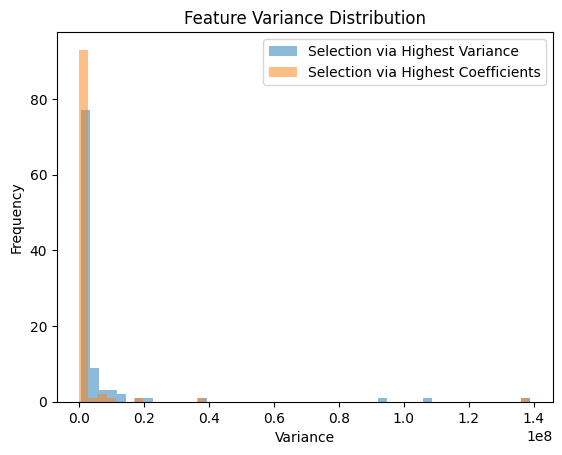

In [42]:
# Get the features selected by:
# - The highest variance 
# - The highest coefficients
X_train_vars = X_train[:, top_100_variances_indices]
X_train_coeffs = X_train[:, top_100_coeffs_indices]

# Get the variances the data selected by:
# - The highest variance
# - The highest coefficients
variances_X_vars = np.var(X_train_vars, axis=0)
variances_X_coeffs = np.var(X_train_coeffs, axis=0)

# Plot the distribution of both variances in a histogram
plt.hist(variances_X_vars, bins=50, alpha=0.5, label="Selection via Highest Variance")
plt.hist(variances_X_coeffs, bins=50, alpha=0.5, label="Selection via Highest Coefficients")
plt.legend(loc="upper right")
plt.title("Feature Variance Distribution")
plt.xlabel("Variance")
plt.ylabel("Frequency")
plt.show()


- Seems like both the feature selection via coefficients and the feature selection via highest variance have a very similar variance distribution (see graph above), which explains why they both performed so similarly in the accuracy test. The difference in their performance is likely due to the fact that the coefficient method of selection came from a linear regression that used L1 regularization, which is known to result in sparse solutions. This means that most of the coefficients will be either 0 or very close to 0, explaining why most of the features selected have both a very similar and very low variance. 
  
  The highest variance method on the other hand, includes other features that have a different and slightly higher variance, probably covering some edge cases that the coefficient method did not, explaining its slightly better performance. 
  
  Its also worth mentioning that both methods have a very small number of outliers with a very high variance, which should consist of most relevant features to properly classify the data. 